## Cats vs Dogs Classification

This notebook uses a neural network to classify cats and dogs based on the images.

Following are the imports required for the project. Tqdm is used to bring out the progress bar when used in a loop.

In [3]:
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

ZipFile uses extractall function to extract images compressed as a zip file

In [ ]:
from zipfile import ZipFile
file_name = "PetImages.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

The path of cats and dogs are provided and cats is labelled as 0 and dogs as 1. Initializing count of both to 0. 

builddata function is used to form data by converting the images into array of integers. Each image is rescaled to 50*50 pixels since all images have to be of same size.

In [ ]:
cat_path = "PetImages/Cat"
dog_path = "PetImages/Dog"
img_size = 50
labels = {cat_path:0,dog_path:1}
cat_count = 0
dog_count = 0
data = []
BUILD = True
    
def builddata():
    cat_count = 0
    dog_count = 0
    for i in labels:
        for j in tqdm(os.listdir(i)):
            try:
                img = cv2.imread(os.path.join(i,j),cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img,(img_size,img_size))
                data.append([np.array(img),np.eye(2)[labels[i]]])
                if(i == cat_path):
                    cat_count += 1
                else:
                    dog_count += 1
            except Exception as e:
                pass
    np.random.shuffle(data)
    np.save("catsvsdogs.npy",data)
    print(f"Dogs : {dog_count} , Cats : {cat_count}")

if BUILD:
    builddata()


Loading the numpy object from saved data.

In [5]:
data = np.load("catsvsdogs.npy",allow_pickle=True)

Plotting one image in gray scale

(375, 500)
(50, 50)


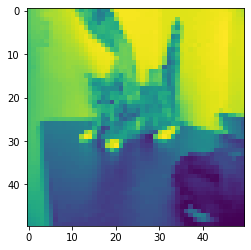

In [6]:

img = cv2.imread("PetImages/Cat/0.jpg",cv2.IMREAD_GRAYSCALE)
print(img.shape)
img = cv2.resize(img,(50,50))
print(img.shape)

plt.imshow(np.array(img))

## Model

The model is built here with 3 dense layers of convolution 2d. The first layer takes in 1 input and produces 32 dimensions of second layer takes in 32D and produces 64D and third layer of input 64D and output 128D. Each layers with 5*5 filters.

We do not know the number of features into the Linear layer which is kind of flattening the model. Thus it is calculated by passing one image and finding out the self.to_linear which gives the shape as input to linear layer.

Two fully connected layers are formed with 1st one taking input of self.to_linear and output of 512 and second one with input 512 and output 2 which are our classes of cats and dogs.

In the model , we are using relu as activation function and max pool 2D with 2*2  as the pooling layer.

The output is formed as the softmax layer outputing the maximum value of the predicted classes.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.cv1 = nn.Conv2d(1,32,5)
        self.cv2 = nn.Conv2d(32,64,5)
        self.cv3 = nn.Conv2d(64,128,5)
        
        self.to_linear = None
        x = torch.randn(50,50).view(-1,1,50,50)
        self.convs(x)
        
        self.fc1 = nn.Linear(self.to_linear,512)
        self.fc2 = nn.Linear(512,2)
    
    def convs(self,x):
        x = F.max_pool2d(F.relu(self.cv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.cv2(x)),(2,2))
        x = F.max_pool2d(F.relu(self.cv3(x)),(2,2))
        
        if self.to_linear is None:
            print(x.shape, x[0].shape)
            self.to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self,x):
        x = self.convs(x)
        x = x.view(-1,self.to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x,dim=1)
        
net = Net()
print(net)

torch.Size([1, 128, 2, 2]) torch.Size([128, 2, 2])
Net(
  (cv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (cv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (cv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


The model is trained using an Adam optimizer and MSE is used in loss function.

In [10]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss = nn.MSELoss()


Next, features and labels are formed. Validation of 10% data is used for testing.

In [11]:
X = torch.Tensor([i[0] for i in data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in data])

In [12]:
val_size = 0.1
val_data = int(val_size * (len(data)))
train_X = X[:-val_data]
train_y = y[:-val_data]

test_X = X[-val_data:]
test_y = y[-val_data:]



In [ ]:
print(len(train_X),len(test_X))

For each epochs, the data is given in batches to the model and is trained.

In [ ]:
BATCH = 10
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0,len(train_X),BATCH)):
        x = train_X[i:i+BATCH].view(-1,1,50,50)
        y = train_y[i:i+BATCH]
        
        output = net(x)
        loss_val = loss(output,y)
        loss_val.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch : {epoch} , Loss : {loss_val}")

The test data is used in testing and accuracy is found out using this model.

In [21]:
correct = 0
total = 0
for i in tqdm(range(len(test_X))):
  actual = torch.argmax(test_y[i])
  preds = net(test_X[i].view(-1,1,50,50))[0]
  pred_val = torch.argmax(preds)
  if pred_val == actual:
    correct += 1
  total += 1
print("Accuracy : ",(correct/total)*100,"%")

100%|██████████| 2494/2494 [00:05<00:00, 426.39it/s]

Accuracy :  54.04971932638332 %


In [ ]:
Here, we got an accuracy of 54% . It could be improved by tuning parameters and increasing more dense layers.